<a href="https://colab.research.google.com/github/danfolador/REDES/blob/main/REDES_Exercicio05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**EXERCÍCIO 05**

Aluno: Daniel Folador Rossi

Matrícula: 20201mpca0306

---

Avalie com validação cruzada o desempenho da ELM em um dataset não-artificial.




In [1]:
#======================================================
# INICIALIZAÇÃO
#======================================================
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_blobs
from sklearn.preprocessing import label_binarize 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate


In [2]:
#======================================================
# FUNCOES AUXILIARES
#======================================================
def PlotaRegiao(X, y, modelo, acuracia):
    
    
    h = 0.05
    x1_min, x1_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    x2_min, x2_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, h),
                           np.arange(x2_min, x2_max, h))
    
    Xreg = np.c_[xx1.ravel(), xx2.ravel()]
    yreg = modelo.predict(Xreg)


    n_classes = len(set(y))
    levmin = min(set(y))-0.01
    levmax = max(set(y))+0.01

    levels=np.linspace(levmin,levmax,n_classes+1)
    cmap=plt.get_cmap('Paired')
    
    PlotaDataSet(X, y, transp=.2)
    plt.annotate('acuracia= ' + str(acuracia), xy=(0.05, 0.05), xycoords='axes fraction', color='red')
    plt.tricontourf(Xreg[:,0], Xreg[:,1], yreg, cmap=cmap, levels=levels, alpha=0.3)
    
    plt.xlim(x1_min, x1_max)
    plt.ylim(x2_min, x2_max)
    
    return Xreg, yreg


def GeraDataSet_SepLin(tamanho=20, centros=4, random_state=None):
    X, y = make_blobs(n_samples=tamanho, centers=centros, center_box=(0,1.0), cluster_std=0.10, random_state=random_state)
    return X, y

def GeraDataSet_NaoSepLin(tamanho=20, centros=[[0,0],[1,0],[1,1],[0,1]], random_state=None):
    X, y = make_blobs(n_samples=tamanho, centers=centros, cluster_std=0.05, random_state=random_state)
    y = np.array(y%2, dtype=int)
    return X, y

def PlotaDataSet(X, y, transp):
    
    x1_min, x1_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    x2_min, x2_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    
    #plota pra cada classe
    for k in set(y):
        logic = y==k
        plt.plot(X[:,0][logic], X[:,1][logic], 'o', alpha=transp)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.xlim(x1_min, x1_max)
    plt.ylim(x2_min, x2_max)

def CriaCategoricos(y):
    replacements = {0:'a', 1:'b', 2:'c', 3:'d', 4:'e', 5:'f'}
    replacer = replacements.get
    y = [replacer(n, n) for n in y]
    return y

def TrataRotulos(y):
    # Substitui por rótulos numéricos
    encoder = LabelEncoder()
    encoder.fit(y)
    y = encoder.transform(y)
    
    # Para o caso binário, substitui por -1/+1
    if len(set(y))<=2: y = y*2-1
    return y

In [3]:
#======================================================
# ALGORITMOS
#======================================================

# PSEUDO-INVERSA
#--------------------------------------------------
class PseudoInversa():
    def __init__(self):
        pass
    def getw(self, X, y):
        w = np.random.uniform(-1, 1,size=(X.shape[1], y.shape[1]))
        pinv = np.linalg.pinv(X)
        w = np.matmul(pinv, y)
        return w

In [4]:
#======================================================
# ELM
#======================================================
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.special import expit


def tanh(a):
    return expit(a)*2-1

class ExtremeLearningMachine(BaseEstimator, ClassifierMixin):
    
    # INIT
    #--------------------------------------------------
    def __init__(self, algoritmo=PseudoInversa(), threshold=0):
        self.wih = None
        self.w = None
        self.threshold = threshold
        #self.activation = lambda a: (a>=0)*2 -1
        self.activation = tanh
        self.algoritmo = algoritmo
    
    # BIAS
    #--------------------------------------------------
    @staticmethod
    def includebias(X):
        bias = np.ones((X.shape[0],1))
        Xb = np.concatenate((bias,X), axis=1)
        return Xb

    # FIT
    #--------------------------------------------------        
    def fit(self,X,y):
        
        #Pesos de input da camada hidden
        #vamos usar k vezes o número de características de X
        k = 3
        self.wih = np.random.uniform(size=(X.shape[1], X.shape[1]*k))
        Xh = np.matmul(X, self.wih)
        Xho = self.activation(Xh)
        X = ExtremeLearningMachine.includebias(Xho)
        
        self.labels = list(set(y))
        y = label_binarize(y, classes=self.labels)*2-1
        
        # Treinamento
        if hasattr(self.algoritmo, 'custo') and not (hasattr(self.algoritmo.custo, 'preactivated') and self.algoritmo.custo.preactivated):
            self.w = self.algoritmo.getw(X, y, self.activation)    
        else:
            self.w = self.algoritmo.getw(X, y)


    # PREDICT
    #--------------------------------------------------     
    def predict(self,X):
        Xh = np.matmul(X, self.wih)
        Xho = self.activation(Xh)       
        Xb = ExtremeLearningMachine.includebias(Xho)  #Vamos usar o bias apenas na camada de saída
        a = np.matmul(Xb, self.w)
            
        #Caso binário
        if self.w.shape[1]<=1:
            logic = self.activation(a) > self.threshold
            idx = np.array(logic, dtype=int)[:,0]
        #Caso multiclasse
        else:
            idx = np.argmax(a, axis=1)
        
        ypred = np.array([self.labels[i] for i in idx])     

        return ypred

In [5]:
#======================================================
# FUNCAO AJUSTE
#======================================================
def Ajuste(Xtrain, Xtest, ytrain, ytest, modelo, plota_vetor):

    # AJUSTE
    #------------------------------------------------------      
    modelo.fit(Xtrain, ytrain)
    #ypred = modelo.predict(Xtest)             #Prediçao com resubstituição
    
    scores = cross_validate(modelo, X, y, scoring = 'accuracy')
    test_score = scores['test_score']
    
    # Caso Binário
    if len(set(ytest))<=2:
        pesos = modelo.w[1:]
        bias = modelo.w[0]
       
    # Caso Multiclasse
    else:
        for i in range(len(set(ytest))):
            pesos = modelo.w[1:,i]
            bias = modelo.w[0,i]

    pesos = modelo.w[1:]
    bias = modelo.w[0]

    
    return pesos, bias, test_score

In [12]:
#======================================================
# BANCO DE DADOS
#======================================================
bd_file = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00429/Cryotherapy.xlsx'
bd = pd.read_excel(bd_file) 
X  = bd.iloc[:, 0:-1]
y = bd.iloc[:, -1]

N_classes = len(set(y))
classes = set(y)


print(bd.head())
print()
print("X.shape=",X.shape)
print("y.shape=",y.shape)
print("No de classes=",N_classes)
print("classes=",classes)


# Mantém apenas duas classes:
cols = X.keys()
cols2keep = {'age', 'Type'}
cols2drop = cols.difference(cols2keep)
print(cols2drop)

X.drop(cols2drop, axis=1, inplace=True)

X = pd.DataFrame.to_numpy(X)
y = pd.DataFrame.to_numpy(y)

   sex  age   Time  Number_of_Warts  Type  Area  Result_of_Treatment
0    1   35  12.00                5     1   100                    0
1    1   29   7.00                5     1    96                    1
2    1   50   8.00                1     3   132                    0
3    1   32  11.75                7     3   750                    0
4    1   67   9.25                1     1    42                    0

X.shape= (90, 6)
y.shape= (90,)
No de classes= 2
classes= {0, 1}
Index(['Area', 'Number_of_Warts', 'Time', 'sex'], dtype='object')


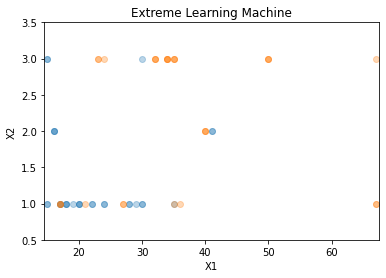

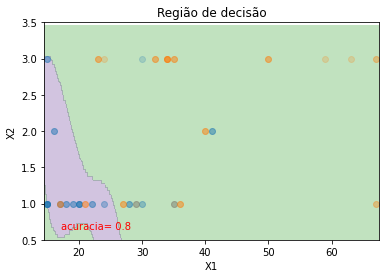


Resultados
--------------------------------------------
bias= [4.60919929e+08]
pesos= [[ 2.76071573e+04]
 [-4.85608206e+08]
 [-3.81866827e+04]
 [ 2.58713776e+07]
 [-8.90199958e+05]
 [-2.82320953e+05]]
acurácias= [0.83333333 0.72222222 0.83333333 0.83333333 0.77777778]
acurácias médias= 0.8



In [11]:
#======================================================
# RODADAS
#======================================================
threshold = 0
modelo = ExtremeLearningMachine(PseudoInversa(),threshold)
    
y=TrataRotulos(y)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.66)

plt.title('Extreme Learning Machine')
PlotaDataSet(Xtest, ytest, transp=0.3)

pesos, bias, test_score = Ajuste(Xtrain, Xtest, ytrain, ytest, modelo, plota_vetor=False)
plt.show()


plt.title('Região de decisão')
PlotaRegiao(X, y, modelo, np.mean(test_score))
plt.show()

print()
print('Resultados')
print('--------------------------------------------')
print('bias=', bias)
print('pesos=', pesos)
print('acurácias=', test_score)
print('acurácias médias=', np.mean(test_score))
print()
